![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Tokenización de textos  

En este taller podrán poner en práctica sus conocimientos sobre preprocesamiento de texto (tokenización). El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos detección de toxicidad en comentarios

En este taller se usará el conjunto de datos de detección de toxicidad en comentarios de la base de datos de Kaggle. Cada observación es un comentario que tiene como variable objetivo (target) la probabilidad de ser un comentario tóxico. El objetivo es predecir la toxicidad de cada comentario. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In [ ]:
# SUGERIDO: Descomenta la siguiente linea de código si requieres instalar las libreías básicas utilizadas en este notebook
# Si requieres incluir más librerías puedes agregarlas al archivo Semana 4\requirements.txt
# !pip install -r requirements.txt

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Importación librerías
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Carga de datos de archivos .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/Toxicity.zip')
df = df[['id','comment_text', 'target']]
df.head()

,id,comment_text,target
0,6101457,What are you talking about? What group do Pete...,0.0
1,5342103,"NO!, Let him, we need a Conservative government.",0.0
2,743361,"Perhaps he took the ""power out of the Cardinal...",0.2
3,551008,"As always, yours is dripping with sarcasm, whi...",0.0
4,865998,The dirty little secret is that the price rang...,0.3


In [4]:
df.shape

(541462, 3)

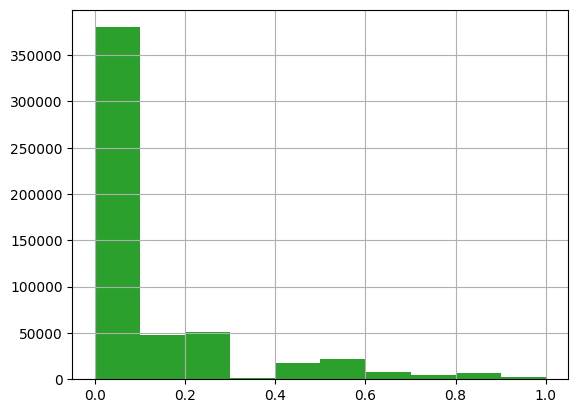

In [12]:
# Impresión histograma de variable de interés (y)
df.target.hist()
plt.show()

In [6]:
# Separación de variable de interés (y)
y = df.target
y.describe()

count    541462.000000
mean          0.102991
std           0.196979
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

In [7]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df.comment_text

In [8]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Punto 1 - Tokenización con CountVectorizer

En la celda 1 creen y entrenen el modelo de regresión de su preferencia, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 1
vect_1 = CountVectorizer()
X_dtm_1 = vect_1.fit_transform(X_train)
X_dtm_1_test = vect_1.transform(X_test)
vect_1.vocabulary_

{'oral': 91127,
 'history': 60749,
 'is': 67439,
 'what': 136457,
 'ever': 46583,
 'they': 125107,
 'say': 110750,
 'it': 67682,
 'nazis': 86202,
 'in': 64454,
 'the': 124581,
 '1930': 1649,
 'did': 38596,
 'eugenic': 46371,
 'experiments': 47347,
 'on': 90518,
 'native': 86035,
 'children': 27384,
 'at': 14725,
 'mcgill': 80014,
 'with': 137734,
 'full': 52599,
 'knowledge': 71877,
 'of': 89814,
 'government': 55832,
 'yup': 139920,
 'if': 63495,
 'happened': 58373,
 'who': 136894,
 'are': 13363,
 'we': 135729,
 'to': 126248,
 'didn': 38619,
 'marijuana': 78894,
 'less': 74583,
 'harmful': 58542,
 'human': 62386,
 'health': 59284,
 'than': 124498,
 'cigarettes': 28085,
 'which': 136645,
 'widely': 137099,
 'used': 132446,
 'and': 11703,
 'there': 124961,
 'no': 87715,
 'ban': 16514,
 'reduces': 104654,
 'stress': 120277,
 'aggression': 9490,
 'level': 74674,
 'leading': 73899,
 'crime': 33788,
 'its': 67777,
 'medical': 80457,
 'value': 132943,
 'favorable': 48684,
 'effects': 43479,


In [23]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_dtm_1, y_train)
X_dtm_1_test = vect_1.transform(X_test)
y_pred_1 = rf.predict(X_dtm_1_test)
mse_1 = metrics.mean_squared_error(y_test, y_pred_1)
mse_1

KeyboardInterrupt: 

## Punto 2 - Tokenización con CountVectorizer y trigramas

En la celda 2 creen y entrenen el mismo modelo de regresión del punto anterior (es decir si usaron un RandomForestRegresor usen nuevamente ese regresor), para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer **considerando trigramas** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 2
vect_tri = CountVectorizer(ngram_range=(3, 3))
X_dtm_tri = vect_tri.fit_transform(X_train)
X_dtm_tri_test = vect_tri.transform(X_test)


In [ ]:
rf_tri = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

## Punto 3 - TfidfVectorizer

Investigen sobre la función TfidfVectorizer. En la celda de texto 3, expliquen en qué consiste esta técnica de tokenización (describanla y expliquen su funcionamiento) y cúales son las ventajas o deventajas de su uso al compararlo con la función CountVectorizer.

In [ ]:
#Celda 3


## Punto 4 - Tokenización con TfidfVectorizer

En la celda 4 creen y entrenen el mismo modelo de regresión del primer punto, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Procesen los comentarios con la función **TfidfVectorizer** y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 4


## Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos y comenten cómo el preprocesamiento de texto afecta el desempeño.

In [ ]:
# Celda 5 Código para graficos y tablas comparativas


In [ ]:
### Punto 5.1 - Comparación y análisis de resultados
